In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt
from cvxopt import matrix

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [10]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  1464


In [11]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [12]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias) # allocate
        
        #YOUR CODE HERE
        N = X.shape[0]
        """
        func = (self._weights) * self._support_vector_labels
        prediction = [np.sum(func) * [self._kernel(X[i], sv) for sv in self._support_vectors] \
                      + self._bias for i in range(N)]
    
        result = np.sign(prediction)
        """
        result = [np.sum(self._weights * self._support_vector_labels * [self._kernel(X[i], sv)
                        for sv in self._support_vectors]) + self._bias for i in range(N)]
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, d = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term (w_0)
        """
        #YOUR CODE HERE
        bias = 0
        for i in range(len(support_vectors)):
            bias += support_vector_labels[i] - np.sum(support_multipliers * support_vector_labels * [self._kernel(sv, support_vectors[i]) for sv in support_vectors])
        
        self._bias=bias/len(support_vectors) if bias != 0 else 0
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape
        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 x^T H x + f^T x
        s.t.
        Ax <=  a
        Bx = b
        """
        N = X.shape[0]
        H = matrix(np.dot(np.dot(np.diag(y), K), np.diag(y).T), tc='d')
        f = matrix(np.array([-1]*N), tc='d')

        A = matrix(np.array([[-1]*N + [1]*N,]*N), tc='d').trans()
        A = matrix(np.vstack((-np.identity(N), np.identity(N))), tc='d')
        a = matrix(np.array([0]*N+[self._c]*N), tc='d')

        B = matrix(np.array([y,]*N), tc='d').trans()
        B = matrix(np.reshape(y, (1, N)), tc='d')
        b = matrix(np.array([0]*N), tc='d')
        b = matrix(0, tc='d')
        
        # call the QP solver
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers (the unknown vector 'x' is our alphas)
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  4


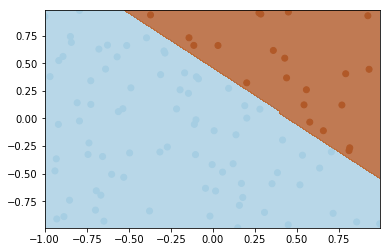

In [13]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  14


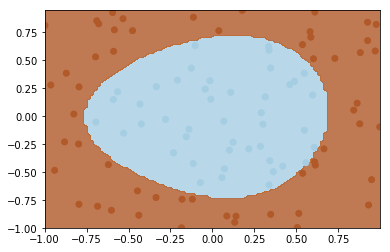

In [14]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [7]:
 for C in [0.01, 0.1, 0.5, 1, 10]:
    clf = SVM(Kernel.linear(), C)
    clf.fit(X['train'], y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(X['train'])
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(X['val'])
    print("Acc on val: ", np.mean(y_hat == y['val']))

SV number:  2052
C =  0.01
Acc on train:  0.797477477477
Acc on val:  0.722
SV number:  1641
C =  0.1
Acc on train:  0.895855855856
Acc on val:  0.732
SV number:  1366
C =  0.5
Acc on train:  0.942342342342
Acc on val:  0.718
SV number:  1268
C =  1
Acc on train:  0.956036036036
Acc on val:  0.724
SV number:  1040
C =  10
Acc on train:  0.995315315315
Acc on val:  0.71


Choose the best C, and predict the label for test data.

In [8]:
C = 0.1
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)


SV number:  1641


RBF (Gaussian) kernel SVM

In [8]:
for C in [0.001, 0.01, 0.1, 0.5, 10, 100]:
    for gamma in [0.1, 0.5, 10]:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(X['val'])
        print("Acc on val: ", np.mean(y_hat == y['val']))
        

SV number:  2352
C =  0.001
gamma =  0.1
Acc on train:  0.636396396396
Acc on val:  0.67


KeyboardInterrupt: 

In [ ]:
clf = SVM(Kernel.gaussian(BEST GAMMA), BEST C)
clf.fit(X['train'], y['train'].astype('double'))y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)
